# Figure 3

FALTA ESTO!!!!

In [102]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import re
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

from Utils.utils import PPT
from Config.config import PATHS
from Utils.utils import GetMeasurements
from Utils.indices import AlternationIndex
from Classes.cognitive_model_agents import FRAplus

### Load AICs

In [103]:
file_all = PATHS['data_likelihoods'] / Path('best_fit_all.json')
df_all = pd.read_json(file_all, lines=True)
df_all.sort_values(by=['AIC', 'model_name'], inplace=True)
df_parameters = df_all[['model_name', 'fixed_parameters', 'free_parameters']]
df_all.drop(columns=['free_parameters', 'fixed_parameters'], inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(-x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['AIC_diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all = df_all[['model_name', 'deviance', 'AIC', 'AIC_diff']].reset_index(drop=['index'])

df_all

,model_name,deviance,AIC,AIC_diff
0,FRA+Payoff+Attendance,18736,37485,0
1,Attendance-M2,18979,37965,480
2,Attendance-M3,19641,39288,1803
3,Attendance-M1,19915,39837,2352
4,MFP-M2,20613,41231,3746
5,MFP-M3,20704,41412,3927
6,AvailableSpace-M3,20765,41537,4052
7,AvailableSpace-M2,20800,41606,4121
8,FRA,20834,41674,4189
9,Fairness-M2,21043,42092,4607


In [104]:
df_parameters.index = df_parameters['model_name']

for model, row in df_parameters.iterrows():
    if model in ['Attendance-M2', 'FRA+Payoff+Attendance']:
        parameters = row['free_parameters']
        print('-'*60)
        print(model)
        print(parameters)

------------------------------------------------------------
FRA+Payoff+Attendance
{'inverse_temperature': 5.1519804836, 'bias': 0.8405926304, 'learning_rate': 0.19721828, 'len_history': 3.9714874373, 'c': 0.720431924, 'delta': 0.1100910541}
------------------------------------------------------------
Attendance-M2
{'inverse_temperature': 5.3035335618, 'learning_rate': 0.18185628750000002, 'bias': 0.8156616184000001}


### Panel A --- Distances between models

In [105]:
# ----- Inputs -----
# models = ['Random', 'WSLS-M1', 'WSLS-M2', 'WSLS-M3', 'Payoff-M1',
#           'Payoff-M2', 'Payoff-M3', 'Attendance-M1', 'Attendance-M2',
#           'Attendance-M3', 'AvailableSpace-M1', 'AvailableSpace-M2',
#           'AvailableSpace-M3', 'Fairness-M1', 'Fairness-M2', 'Fairness-M3',
#           'MFP-M1', 'MFP-M2', 'MFP-M3', 'FRA', 'FRA+Payoff+Attendance']

models = df_all['model_name'].values

mechanisms = ['Stochastic', 'Heuristic', 'Best-response', 'Error-correction', 'Schemata']
m2i = {
    'Stochastic': 0,
    'Heuristic': 1,
    'Best-response': 3,
    'Error-correction': 4,
    'Schemata': 5
}

# For each *base* model, list which high-level mechanisms it belongs to (by index).
dict_mechanisms = {
    'FRA+Payoff+Attendance': [4, 5],   # Error-correction + Schemata
    'FRA': [5],                        # Schemata
    'Attendance': [4],                 # Error-correction
    'Payoff': [4],                     # Error-correction
    'Fairness': [4],                   # Error-correction
    'AvailableSpace': [4],             # Error-correction
    'MFP': [3],                        # Best-response
    'WSLS': [1],                       # Heuristic
    'Random': [0]                      # Stochastic
}

# For each *base* model, list which high-level mechanisms it belongs to (by index).
dict_x = {
    'FRA+Payoff+Attendance': 6,
    'FRA': 7,
    'Attendance': 5.5,
    'Payoff': 5,
    'Fairness': 4,
    'AvailableSpace': 3,
    'MFP': 1,
    'WSLS': 0,
    'Random': -2
}

In [106]:
# ----- Helpers -----
level_pattern = re.compile(r'-M(\d+)$')

def parse_base_and_level(model_name: str):
    """Return (base_name, level:int). If no level in the name, level=0."""
    m = level_pattern.search(model_name)
    if m:
        level = int(m.group(1))
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
        level = 0
    return base, level

def base_for_model(model_name: str):
    """Return base_name"""
    m = level_pattern.search(model_name)
    if m:
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
    return base

def mechanisms_for_model(model_name: str):
    """Return a set of mechanism indices for the given model name."""
    base, _ = parse_base_and_level(model_name)
    mech_list = dict_mechanisms.get(base, [])
    return set(mech_list)

def level_for_model(model_name: str):
    """Numeric level (ordinal). Models without -M# are treated as level 0."""
    base, lvl = parse_base_and_level(model_name)
    if base == 'Random':
        lvl = 1
    elif 'FRA' in base:
        lvl = 2.5
    return lvl

def model_distance(a: str, b: str):
    """Distance = 1/(#shared_mechanisms) + |level_a - level_b|; ∞ if none shared."""
    ma = mechanisms_for_model(a)
    mb = mechanisms_for_model(b)
    shared = len(ma & mb)
    if base_for_model(a) == base_for_model(b):
        m_distance = 0
    elif shared == 0:
        m_distance = 2
    else:
        m_distance = 1.0 / shared
    return m_distance

In [107]:
# Coordinates for mechanisms
X = np.array([dict_x[base_for_model(x)] for x in models], dtype=float)
Y = np.array([level_for_model(x) for x in models], dtype=float)

emb_df = pd.DataFrame({
    'model': models,
    'mechanism_axis': X,  # learned 1D mechanism embedding
    'level': Y,             # explicit ordinal level axis
    'AIC': df_all['AIC'].values,
    'AIC_diff': df_all['AIC_diff'].values
})

emb_df

,model,mechanism_axis,level,AIC,AIC_diff
0,FRA+Payoff+Attendance,6.0,2.5,37485,0
1,Attendance-M2,5.5,2.0,37965,480
2,Attendance-M3,5.5,3.0,39288,1803
3,Attendance-M1,5.5,1.0,39837,2352
4,MFP-M2,1.0,2.0,41231,3746
5,MFP-M3,1.0,3.0,41412,3927
6,AvailableSpace-M3,3.0,3.0,41537,4052
7,AvailableSpace-M2,3.0,2.0,41606,4121
8,FRA,7.0,2.5,41674,4189
9,Fairness-M2,4.0,2.0,42092,4607


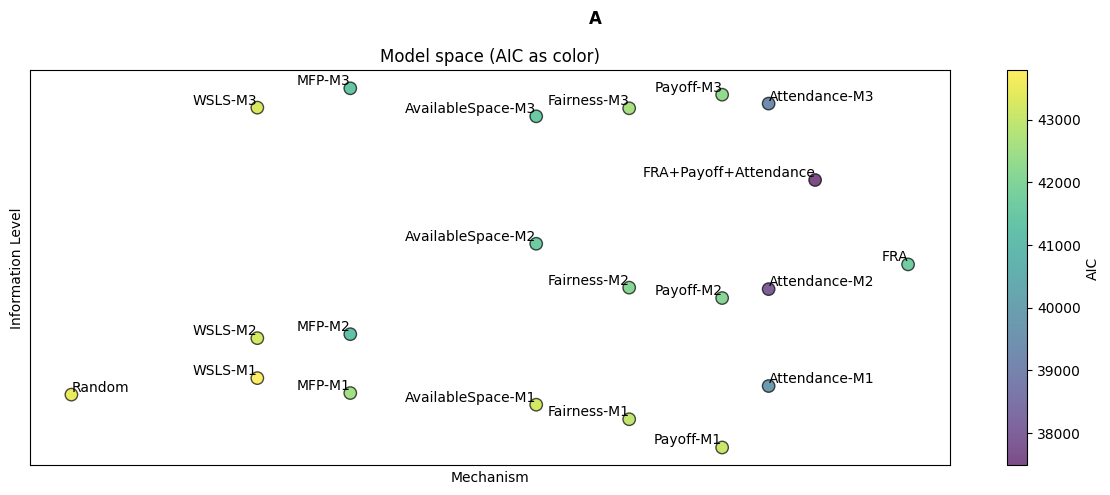

In [108]:
# ----- Quick plot -----
# add vertical jitter
rng = np.random.default_rng(42)  # for reproducibility
jitter = rng.uniform(0, 1, size=len(emb_df))  # small noise around 0
emb_df['level_jittered'] = emb_df['level'] + jitter

# Scatter plot with color by AIC
fig, ax = plt.subplots(
    1, 1, 
    figsize=(12,5), 
    tight_layout=True
)

sc = plt.scatter(
    emb_df['mechanism_axis'], emb_df['level_jittered'],
    c=emb_df['AIC'], s=80, cmap='viridis', alpha=0.7, edgecolor='k', 
)

# Labels for each point
for _, row in emb_df.iterrows():
    if (('Attendance' in row['model']) and ('FRA' not in row['model'])) or ('Random' in row['model']):
        ha = 'left'
    else:
        ha = 'right'
    plt.text(row['mechanism_axis'], row['level_jittered'],
             row['model'], fontsize=10, ha=ha, va='bottom')

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label('AIC')

# Axes labels and title
plt.xlabel('Mechanism')
plt.xticks(ticks=[])
plt.ylabel('Information Level')
plt.yticks(ticks=[])
plt.title('Model space (AIC as color)')

# Convert figure to image array
fig.suptitle("A", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_A = np.array(pil_image)

### Simulate best fit model

Best fit model simulated at HPC

### Panel B --- Display simulated best-fit model against human data

In [109]:
def get_num_rounds(num_agents) -> int:
    if num_agents == 2:
        return 50
    elif num_agents == 3:
        return 45
    else:
        return 30

# Load human data
human_data_folder = PATHS['human_data']
file_name = 'all_data.csv'
file = human_data_folder / Path(file_name)
data_human = pd.read_csv(file)
data_human['model'] = 'human'
data_human['round'] = data_human.apply(lambda x: x['round'] % get_num_rounds(x['num_players']), axis=1)

# Calculate measures for human data
gm = GetMeasurements(
    data=data_human,
    measures=['efficiency', 'bounded_efficiency', 'inequality', 'bounded_inequality'],
    T=np.inf
)
measures_human = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
measures_human['alternation_index'] = alt_index(measures_human)

# Load simulated data
BEST_MODEL = FRAplus
sim_data_folder = PATHS['simulated_data']
file_name = 'FRAplus_measured.csv'
file = sim_data_folder / Path(file_name)
measures_best_fit = pd.read_csv(file)
measures_best_fit['model'] = BEST_MODEL.name()

# Concatenate human and simulated data
df1 = pd.concat([measures_human, measures_best_fit], ignore_index=True)
# df1 = pd.concat([measures_human], ignore_index=True)
df_jitter1 = df1.copy()
df_jitter1['bounded_efficiency'] = df_jitter1['bounded_efficiency'] + np.random.normal(0, 0.01, len(df_jitter1['bounded_efficiency']))
df_jitter1['bounded_inequality'] = df_jitter1['bounded_inequality'] + np.random.normal(0, 0.01, len(df_jitter1['bounded_inequality']))



In [110]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data_human.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions

group_counter = {grp:0 for grp in data_human['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data_human.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data_human.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(num_players, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(num_players, threshold)] = count
    else:
        dict_sessions_downwards[(num_players, threshold)] = 1

dict_sessions = {
    'score + grid': {
        (2, 0.5): 1
    },
    'only score': {
        (2, 0.5): 1
    },
    'upwards': dict_sessions_upwards,
    'downwards': dict_sessions_downwards
}

In [111]:
folder = PATHS['simulated_data']
df_list = []
for p in folder.iterdir():
    if p.is_file() and p.suffix.lower() == ".csv" and p.name.startswith(BEST_MODEL.name()):
        df = pd.read_csv(p)
        df_list.append(df)

data_sim = pd.concat(df_list, ignore_index=True)
data_sim['treatment'] = data_sim['model'].apply(lambda x: x.split('_')[-1])

data = PPT.concat_dfs(data_human, data_sim)

data['session'] = data.apply(lambda row: dict_sessions[row['treatment']][(int(row['num_agents']), row['threshold'])], axis=1)
data['model'] = data['model'].apply(lambda x: BEST_MODEL.name() if x != 'human' else x)
data.head(2)
# 

,model,treatment,threshold,num_agents,id_sim,id_player,round,decision,score,session
0,human,downwards,0.375,8,11,312023415382283,2.0,1.0,-1.0,3
1,human,downwards,0.375,8,11,608233835868441,2.0,1.0,-1.0,3


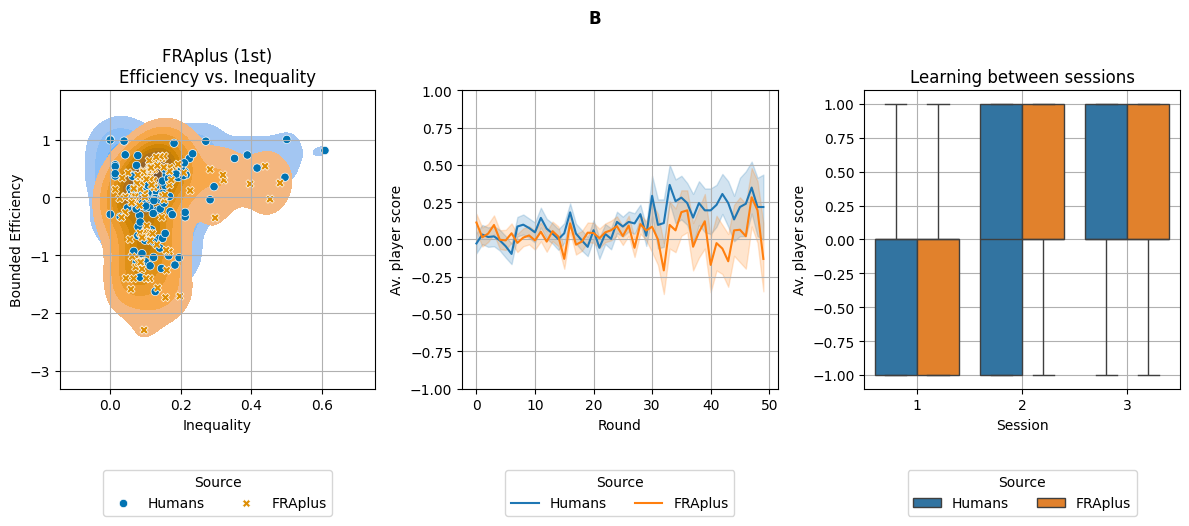

In [112]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(12, 5),
    tight_layout=True,
    sharex=False, sharey=False    
)

sns.kdeplot(
    x='inequality', y='bounded_efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind', fill=True,
    ax=axes[0]
)
sns.scatterplot(
    x='inequality', y='bounded_efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind',
    ax=axes[0]
)
axes[0].set_xlabel('Inequality')
axes[0].set_ylabel('Bounded Efficiency')
axes[0].set_title('FRAplus (1st)\nEfficiency vs. Inequality')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
    title='Source',
    handles=handles,
    labels=['Humans', 'FRAplus'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.45),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)
axes[0].grid()

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', 
    hue='model',
    data=data,
    ci=95, ax=axes[1]
)
axes[1].set_xlabel('Round')
axes[1].set_ylabel("Av. player score")
axes[1].grid()
axes[1].set_ylim([-1,1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    title='Source',
    handles=handles,
    labels=['Humans', 'FRAplus'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.45),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)

# Learning: average score increases per session
sns.boxplot(
    x='session', y='score', 
    hue='model',
    data=data, ax=axes[2],
)
axes[2].set_xlabel('Session')
axes[2].set_ylabel("Av. player score")
axes[2].set_title("Learning between sessions")
axes[2].grid()
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(
    title='Source',
    handles=handles,
    labels=['Humans', 'FRAplus'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.45),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)

# Convert figure to image array
fig.suptitle("B", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_B = np.array(pil_image)

### Panels A and B

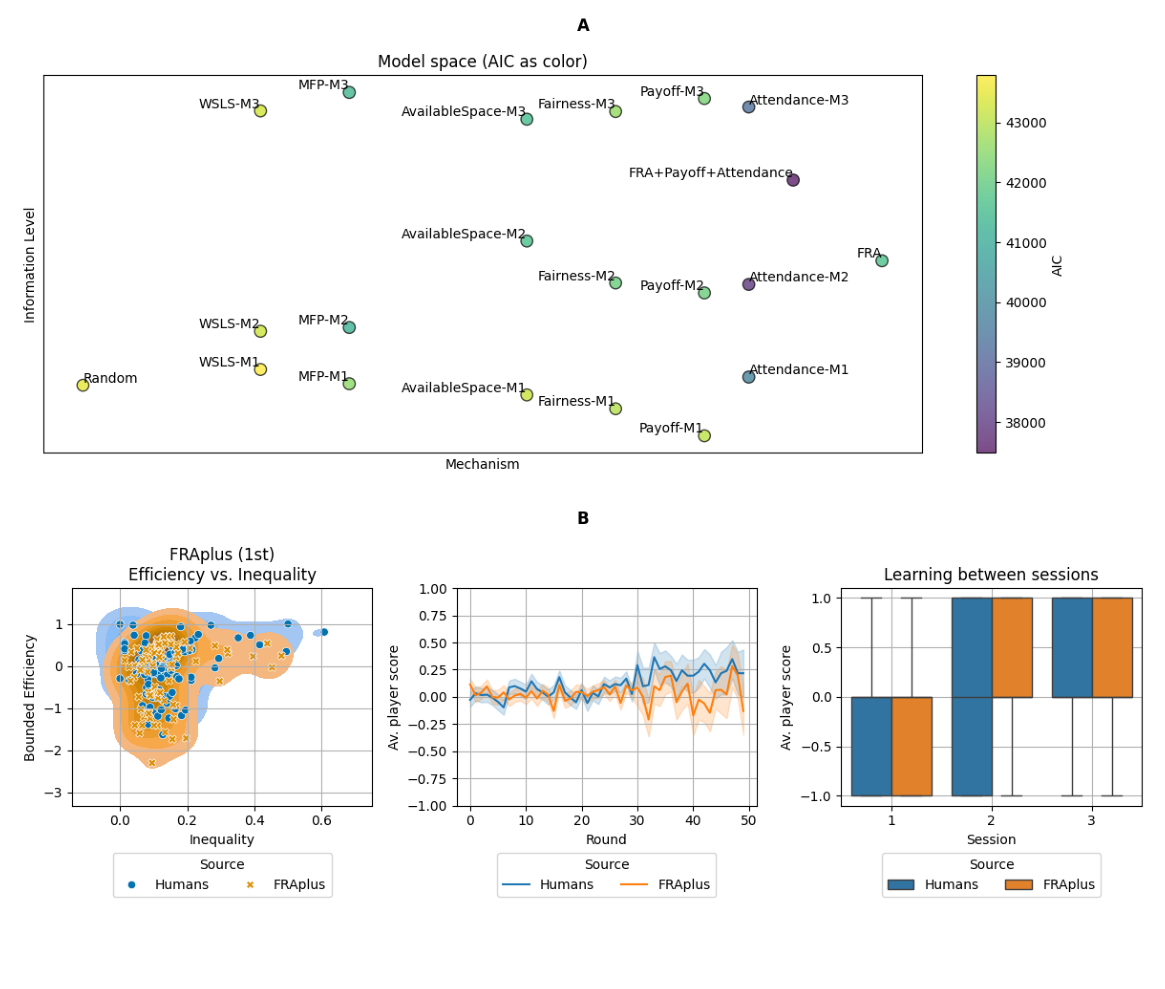

In [113]:
fig, ax = plt.subplots(2, 1, figsize=(12,10), tight_layout=True)

ax[0].imshow(panel_A)  
ax[1].imshow(panel_B)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B = np.array(pil_image)

In [114]:
fig.savefig(PATHS['figures_for_paper'] / 'Short_Fig3.png', dpi=300, bbox_inches='tight')

---